# CELL 1

In [1]:
!pip install --upgrade ipywidgets jupyter

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# Không cần openpyxl vì là file CSV
# !pip install openpyxl -q
# For Vietnamese word_segment
!pip install pyvi -q
# Transformers library from Hugging Face
!pip install transformers[torch] -q # Cài đặt kèm PyTorch
# Cài đặt scikit-learn để dùng StratifiedKFold và metrics
!pip install scikit-learn -q
# Cài đặt seaborn và matplotlib để vẽ biểu đồ
!pip install seaborn matplotlib -q
# Cài đặt gensim để dùng simple_preprocess
!pip install gensim -q


import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyvi import ViTokenizer
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error() # Chỉ hiển thị lỗi từ thư viện transformers

# --- Constants ---
SEED = 42
N_SPLITS = 5
EPOCHS = 4
LEARNING_RATE = 2e-5
MAX_LEN = 180 # Xem xét lại sau khi chạy Cell 4
BATCH_SIZE = 16

# --- File and Column Names ---
CSV_FILE_PATH = 'reviews_AT.csv'
COMMENT_COLUMN = 'Comment'
LABEL_COLUMN = 'Label' # Cột chứa nhãn số (0, 1, 2 - GIẢ ĐỊNH)
# -----------------------------------------------------------

# --- Reproducibility ---
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Định nghĩa số lớp và tên lớp ---
# *** SỬA ĐỔI CHO 3 LỚP ***
N_CLASSES = 3
# GIẢ ĐỊNH: 0 = Tiêu cực, 1 = Trung bình, 2 = Tích cực. Kiểm tra lại file CSV!
CLASS_NAMES = ['Tiêu cực', 'Trung bình', 'Tích cực']
print(f"Number of classes: {N_CLASSES}")
print(f"Class names: {CLASS_NAMES}")

Using device: cuda:0
Number of classes: 3
Class names: ['Tiêu cực', 'Trung bình', 'Tích cực']


# CELL 2 

Successfully read CSV file: reviews_AT.csv
Original number of samples: 2561
Number of samples after cleaning: 2561

Label distribution:
Label
0     574
1     434
2    1553
Name: count, dtype: int64

Sample data with kfold column:
                                               Sentence  Label  kfold
2157                             Bình gọn đẹp, xài khoẻ      2      4
1738  sản phẩm dùng tốt, mua cho người thân sử dụng,...      2      3
1173  tạm ổn sủ dụng nhu cầu gia đình ép vẫn hơi bã ...      2      0
478       quá tuyệt sẽ giới thiệu cho bạn bè người thân      2      0
1356  máy ép ra cặn quá nhiều, không xứng với giá ti...      0      3

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561 entries, 0 to 2560
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2561 non-null   object
 1   Label     2561 non-null   int64 
 2   kfold     2561 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 

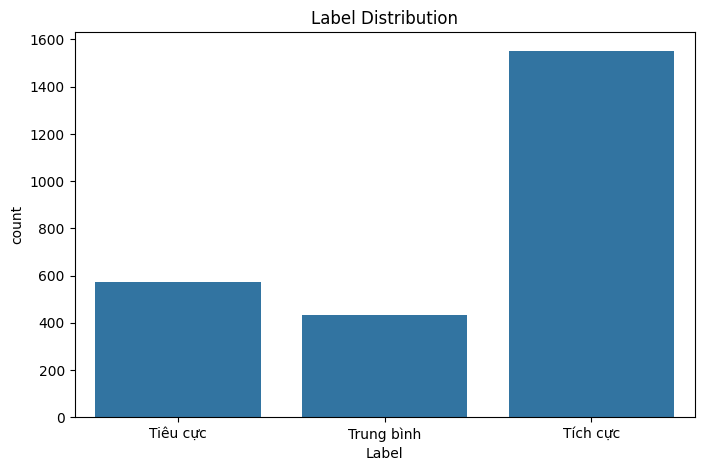

In [3]:
def load_and_prepare_data(path, comment_col, label_col):
    try:
        df = pd.read_csv(path)
        print(f"Successfully read CSV file: {path}")
        print(f"Original number of samples: {len(df)}")

        if comment_col not in df.columns or label_col not in df.columns:
             raise ValueError(f"Missing required columns: '{comment_col}' or '{label_col}'")

        # Chọn cột, đổi tên, xử lý NaN và kiểu dữ liệu
        df = df[[comment_col, label_col]].copy()
        df.columns = ['Sentence', 'Label'] # Đổi tên cột nhãn thành 'Label'
        df.dropna(subset=['Sentence', 'Label'], inplace=True)
        df['Sentence'] = df['Sentence'].astype(str)
        df['Label'] = df['Label'].astype(int) # Nhãn đã là số (0, 1, 2)

        # *** BỎ BƯỚC MAPPING NHÃN ***

        # Chỉ giữ lại các nhãn hợp lệ (0, 1, 2)
        valid_labels = list(range(N_CLASSES)) # Tạo danh sách [0, 1, 2]
        original_count = len(df)
        df = df[df['Label'].isin(valid_labels)]
        removed_count = original_count - len(df)
        if removed_count > 0:
            print(f"Warning: Removed {removed_count} samples with invalid labels (not in {valid_labels}).")


        # Bỏ comment rỗng
        df = df[df['Sentence'].str.strip().str.len() > 0]

        print(f"Number of samples after cleaning: {len(df)}")
        if len(df) == 0:
             print("Error: No valid data remaining after cleaning.")
             return None


        print("\nLabel distribution:")
        print(df['Label'].value_counts().sort_index()) # Sắp xếp theo index (0, 1, 2)


        return df.reset_index(drop=True)

    except FileNotFoundError:
        print(f"Error: File not found at '{path}'")
        return None
    except ValueError as ve:
        print(f"Error: {ve}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        return None


# Load dữ liệu từ file CSV của bạn
all_df = load_and_prepare_data(CSV_FILE_PATH, COMMENT_COLUMN, LABEL_COLUMN)


if all_df is not None:
    # --- Tạo cột K-Fold ---
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    # Sử dụng cột 'Label' (0, 1, 2) để stratify
    for fold, (_, val_idx) in enumerate(skf.split(X=all_df, y=all_df['Label'])):
        all_df.loc[val_idx, "kfold"] = fold
    all_df['kfold'] = all_df['kfold'].astype(int)


    print("\nSample data with kfold column:")
    print(all_df.sample(5))


    print("\nData Info:")
    all_df.info()


    # Vẽ biểu đồ phân bố nhãn
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Label', data=all_df, order=sorted(all_df['Label'].unique()))
    plt.title('Label Distribution')
    # Gán tên lớp cho trục x
    plt.xticks(ticks=range(N_CLASSES), labels=CLASS_NAMES)
    plt.show()
else:
    print("\nCould not load data. Please check the file path and column names.")

# CELL 3

In [4]:
# Load tokenizer PhoBERT
try:
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
    print("PhoBERT tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    # exit()

class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=MAX_LEN):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        try:
            text = row['Sentence']
            # *** LẤY NHÃN GỐC (0, 1, 2) TỪ CỘT 'Label' ***
            label = row['Label']

            # Tiền xử lý văn bản
            processed_text = ' '.join(simple_preprocess(text))
            tokenized_text = ViTokenizer.tokenize(processed_text)

        except Exception as e:
            print(f"Error processing data at index {index}: {e}")
            return None

        # Encode văn bản
        try:
            encoding = self.tokenizer.encode_plus(
                tokenized_text,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt',
            )
        except Exception as e:
             print(f"Error encoding text at index {index}: '{tokenized_text[:50]}...'. Error: {e}")
             return None

        return {
            'text': tokenized_text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long), # Nhãn gốc đã là số (0, 1, 2)
        }

# Hàm collate_fn (giữ nguyên)
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    elem = batch[0]
    keys = elem.keys()
    collated_batch = {}
    for key in keys:
        if key == 'text':
            collated_batch[key] = [d[key] for d in batch]
        else:
            collated_batch[key] = torch.stack([d[key] for d in batch])
    return collated_batch

print("SentimentDataset class defined (using original 0, 1, 2 labels).")

PhoBERT tokenizer loaded successfully.
SentimentDataset class defined (using original 0, 1, 2 labels).


# Cell 4: Check Max Length 

Analyzing token lengths for the dataset...


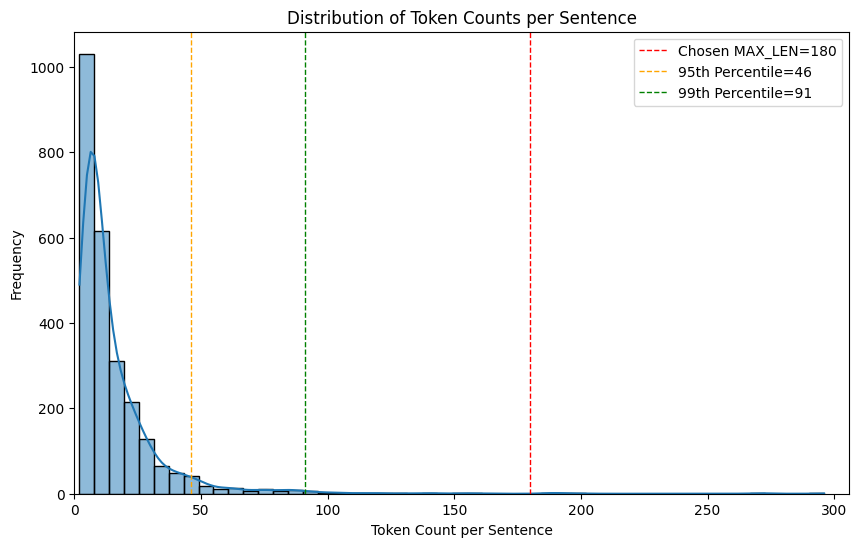

Suggested MAX_LEN: Consider a value around 46 (95th) or 91 (99th).
Current MAX_LEN is set to: 180


In [5]:
if all_df is not None:
    print("Analyzing token lengths for the dataset...")
    all_sentences = all_df['Sentence'].tolist()
    processed_sentences = [' '.join(simple_preprocess(text)) for text in all_sentences]
    tokenized_vi_sentences = [ViTokenizer.tokenize(text) for text in processed_sentences]
    encoded_texts = [tokenizer.encode(text, add_special_tokens=True) for text in tokenized_vi_sentences]
    token_lens = [len(text) for text in encoded_texts]

    plt.figure(figsize=(10, 6))
    sns.histplot(token_lens, bins=50, kde=True)
    percentile_95 = np.percentile(token_lens, 95)
    percentile_99 = np.percentile(token_lens, 99)
    plt.xlim([0, max(token_lens) + 10])
    plt.xlabel('Token Count per Sentence')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Counts per Sentence')
    plt.axvline(MAX_LEN, color='red', linestyle='dashed', linewidth=1, label=f'Chosen MAX_LEN={MAX_LEN}')
    plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=1, label=f'95th Percentile={percentile_95:.0f}')
    plt.axvline(percentile_99, color='green', linestyle='dashed', linewidth=1, label=f'99th Percentile={percentile_99:.0f}')
    plt.legend()
    plt.show()

    print(f"Suggested MAX_LEN: Consider a value around {percentile_95:.0f} (95th) or {percentile_99:.0f} (99th).")
    print(f"Current MAX_LEN is set to: {MAX_LEN}")
else:
    print("Cannot analyze token lengths because data loading failed.")

In [6]:
# Cell 5: Model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=N_CLASSES): # Sử dụng N_CLASSES=3 từ config
        super(SentimentClassifier, self).__init__()
        print(f"Initializing SentimentClassifier for {n_classes} classes...")
        try:
            self.bert = AutoModel.from_pretrained("vinai/phobert-base")
            print("Pre-trained PhoBERT base model loaded.")
        except Exception as e:
            print(f"Error loading PhoBERT model: {e}")
            raise

        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)
        print(f"Classifier head initialized.")

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        pooler_output = outputs.pooler_output
        x = self.drop(pooler_output)
        x = self.fc(x)
        return x

print("SentimentClassifier class defined.")

SentimentClassifier class defined.


# CELL 6

In [7]:
# # Import tqdm nếu chưa import
# from tqdm.notebook import tqdm

# def train_epoch(model, criterion, optimizer, scheduler, train_loader, epoch, n_epochs, device):
#     model.train()
#     losses = []
#     correct_predictions = 0
#     total_samples = 0
#     progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Train]', leave=False)

#     for data in progress_bar:
#         if data is None: continue
#         input_ids = data['input_ids'].to(device)
#         attention_mask = data['attention_masks'].to(device)
#         targets = data['targets'].to(device)

#         optimizer.zero_grad()
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         loss = criterion(outputs, targets)
#         _, preds = torch.max(outputs, dim=1)
#         correct_predictions += torch.sum(preds == targets)
#         total_samples += targets.size(0)
#         losses.append(loss.item())
#         loss.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         if scheduler: scheduler.step()
#         progress_bar.set_postfix(loss=loss.item())

#     epoch_loss = np.mean(losses) if losses else 0
#     epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else 0
#     print(f'Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.4f}')
#     return epoch_loss, epoch_acc


# def eval_model(model, criterion, data_loader, device, mode='Validation', n_epochs=EPOCHS, epoch=0):
#     model.eval()
#     losses = []
#     correct_predictions = 0
#     total_samples = 0
#     progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{n_epochs} [{mode}]', leave=False)

#     with torch.no_grad():
#         for data in progress_bar:
#             if data is None: continue
#             input_ids = data['input_ids'].to(device)
#             attention_mask = data['attention_masks'].to(device)
#             targets = data['targets'].to(device)
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             _, preds = torch.max(outputs, dim=1)
#             loss = criterion(outputs, targets)
#             correct_predictions += torch.sum(preds == targets)
#             total_samples += targets.size(0)
#             losses.append(loss.item())

#     epoch_loss = np.mean(losses) if losses else 0
#     epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else 0
#     print(f'{mode} Loss: {epoch_loss:.4f} | {mode} Accuracy: {epoch_acc:.4f}')
#     return epoch_loss, epoch_acc
# Cell 6 (SỬ DỤNG tqdm CƠ BẢN)

# Import tqdm bản cơ bản (không cần ipywidgets)
# Cell 6 (SỬ DỤNG tqdm CƠ BẢN - KIỂM TRA LẠI!)

# Import tqdm bản cơ bản (không cần ipywidgets)
from tqdm import tqdm # <<< QUAN TRỌNG: Đảm bảo là 'from tqdm import tqdm'
import numpy as np
import torch
import traceback

def train_epoch(model, criterion, optimizer, scheduler, train_loader, epoch, n_epochs, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0
    # Sử dụng tqdm bản cơ bản
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Train]', leave=True, unit="batch")

    for data in progress_bar:
        if data is None: continue
        try:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, targets)
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets)
            total_samples += targets.size(0)
            losses.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if scheduler: scheduler.step()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", refresh=True)
        except Exception as e_batch:
             print(f"\nError in training batch: {e_batch}")
             continue

    epoch_loss = np.mean(losses) if losses else float('nan')
    epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else float('nan')
    print(f'Epoch {epoch+1}/{n_epochs} [Train] Completed - Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc


def eval_model(model, criterion, data_loader, device, mode='Validation', n_epochs=EPOCHS, epoch=0):
    model.eval()
    losses = []
    correct_predictions = 0
    total_samples = 0
    # Sử dụng tqdm bản cơ bản
    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{n_epochs} [{mode}]', leave=True, unit="batch")

    with torch.no_grad():
        for data in progress_bar:
            if data is None: continue
            try:
                input_ids = data['input_ids'].to(device)
                attention_mask = data['attention_masks'].to(device)
                targets = data['targets'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs, dim=1)
                loss = criterion(outputs, targets)
                correct_predictions += torch.sum(preds == targets)
                total_samples += targets.size(0)
                losses.append(loss.item())
                progress_bar.set_postfix(loss=f"{loss.item():.4f}", refresh=True)
            except Exception as e_batch_eval:
                 print(f"\nError in evaluation batch: {e_batch_eval}")
                 continue

    epoch_loss = np.mean(losses) if losses else float('nan')
    epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else float('nan')
    print(f'Epoch {epoch+1}/{n_epochs} [{mode}] Completed - {mode} Loss: {epoch_loss:.4f} | {mode} Accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

print("Training and Evaluation functions defined (using basic tqdm).")

Training and Evaluation functions defined (using basic tqdm).


# Cell 7: Training with K-Fold

In [8]:
# Import tqdm nếu chưa import ở cell trước
from tqdm import tqdm
# Instead of PyTorch's AdamW
from torch.optim import AdamW# Use this one which has correct_bias parameter
import traceback # Để in chi tiết lỗi nếu có

def prepare_loaders(df, fold, tokenizer, max_len, batch_size):
    """Chia dữ liệu và tạo DataLoaders cho một fold."""
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    print(f"Fold {fold+1}: Train size={len(df_train)}, Valid size={len(df_valid)}")

    if len(df_train) == 0 or len(df_valid) == 0:
        print(f"Warning: Empty train or validation set for fold {fold+1}. Skipping this fold.")
        return None, None # Trả về None nếu không có dữ liệu

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=max_len)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=max_len)

    try:
        # Sử dụng num_workers=0 để đơn giản và ổn định hơn
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
        # Kiểm tra nhanh xem DataLoader có rỗng không (mặc dù collate_fn đã xử lý None items)
        if len(train_loader) == 0 or len(valid_loader) == 0:
             print(f"Warning: DataLoader is empty for fold {fold+1} after creation. Skipping.")
             return None, None
        return train_loader, valid_loader
    except Exception as e:
        print(f"Error creating DataLoader for fold {fold+1}: {e}")
        print(traceback.format_exc()) # In chi tiết lỗi
        return None, None


# --- Biến lưu lịch sử và kết quả tốt nhất ---
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_fold_accuracies = []
failed_folds = [] # Theo dõi các fold bị lỗi

if all_df is not None:
    # --- Vòng lặp K-Fold ---
    for fold in range(N_SPLITS):
        print(f'\n===== Fold: {fold+1}/{N_SPLITS} =====')
        fold_successful = True # Cờ để đánh dấu fold này có thành công không
        best_val_acc = 0.0 # Reset best accuracy cho fold mới
        fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        try:
            # Chuẩn bị DataLoader cho fold hiện tại
            train_loader, valid_loader = prepare_loaders(all_df, fold, tokenizer, MAX_LEN, BATCH_SIZE)

            # Bỏ qua fold này nếu DataLoader không được tạo
            if train_loader is None or valid_loader is None:
                failed_folds.append(fold + 1)
                continue # Chuyển sang fold tiếp theo

            # Khởi tạo lại model, criterion, optimizer, scheduler
            model = SentimentClassifier(n_classes=N_CLASSES).to(device)
            criterion = nn.CrossEntropyLoss().to(device)
            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

            # Tính tổng số bước huấn luyện (phải > 0)
            num_training_steps = len(train_loader) * EPOCHS
            if num_training_steps <= 0:
                 print(f"Warning: num_training_steps is zero or negative ({num_training_steps}) for fold {fold+1}. Skipping scheduler/training.")
                 failed_folds.append(fold + 1)
                 continue

            num_warmup_steps = int(0.1 * num_training_steps)
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=num_warmup_steps,
                num_training_steps=num_training_steps
            )

            # Vòng lặp qua các Epoch
            for epoch in range(EPOCHS):
                print(f'\n--- Epoch {epoch+1}/{EPOCHS} ---')
                try:
                    # Huấn luyện
                    train_loss, train_acc = train_epoch(model, criterion, optimizer, scheduler, train_loader, epoch, EPOCHS, device)
                    # Đánh giá
                    val_loss, val_acc = eval_model(model, criterion, valid_loader, device, mode='Validation', n_epochs=EPOCHS, epoch=epoch)

                    # Lưu lịch sử epoch này
                    fold_history['train_loss'].append(train_loss)
                    fold_history['train_acc'].append(train_acc)
                    fold_history['val_loss'].append(val_loss)
                    fold_history['val_acc'].append(val_acc)

                    # Lưu model nếu validation accuracy tốt hơn và hợp lệ
                    if torch.isfinite(torch.tensor(val_acc)) and val_acc > best_val_acc:
                        print(f"Validation accuracy improved ({best_val_acc:.4f} --> {val_acc:.4f}). Saving model...")
                        model_save_path = f'phobert_sentiment_fold{fold+1}.pth'
                        try:
                            torch.save(model.state_dict(), model_save_path)
                            print(f"Model saved to {model_save_path}")
                            best_val_acc = val_acc
                        except Exception as e_save:
                            print(f"Error saving model for epoch {epoch+1}, fold {fold+1}: {e_save}")
                    elif not torch.isfinite(torch.tensor(val_acc)):
                        print(f"Warning: Invalid validation accuracy ({val_acc}) encountered in epoch {epoch+1}. Not saving model.")

                except Exception as e_epoch:
                    print(f"\n!!! Error occurred during Epoch {epoch+1} for Fold {fold+1}: {e_epoch} !!!")
                    print(traceback.format_exc())
                    print("Attempting to continue to the next epoch/fold...")
                    fold_successful = False # Đánh dấu fold này thất bại
                    # Có thể thêm break ở đây nếu muốn dừng fold ngay khi có lỗi epoch
                    # break # Bỏ comment nếu muốn dừng fold khi gặp lỗi epoch

            # Kết thúc vòng lặp epoch cho fold hiện tại
            if fold_successful:
                print(f"\nBest Validation Accuracy for Fold {fold+1}: {best_val_acc:.4f}")
                best_fold_accuracies.append(best_val_acc)
                # Lưu lịch sử của fold thành công vào history tổng
                for key in history:
                     history[key].extend(fold_history[key])
            else:
                print(f"\nFold {fold+1} encountered errors and might not have completed successfully.")
                failed_folds.append(fold + 1)


        except Exception as e_fold:
            # Xử lý lỗi xảy ra ngoài vòng lặp epoch (ví dụ: khi khởi tạo model/optimizer)
            print(f"\n!!! Error occurred processing Fold {fold+1}: {e_fold} !!!")
            print(traceback.format_exc())
            failed_folds.append(fold + 1)
            continue # Chuyển sang fold tiếp theo


    # --- Kết thúc vòng lặp K-Fold ---
    print(f'\n===== Training Complete =====')
    if best_fold_accuracies:
        print(f"Successfully trained {len(best_fold_accuracies)}/{N_SPLITS} folds.")
        print(f"Average Best Validation Accuracy across successful folds: {np.mean(best_fold_accuracies):.4f}")
        if failed_folds:
             print(f"Failed folds: {sorted(list(set(failed_folds)))}") # In ra các fold bị lỗi (loại bỏ trùng lặp)
    else:
        print(f"No folds were trained successfully. Failed folds: {sorted(list(set(failed_folds)))}")


else:
    print("Cannot start training because data loading failed (all_df is None).")


===== Fold: 1/5 =====
Fold 1: Train size=2048, Valid size=513
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.

--- Epoch 1/4 ---


Epoch 1/4 [Train]: 100%|██████████| 128/128 [00:51<00:00,  2.49batch/s, loss=0.9048]


Epoch 1/4 [Train] Completed - Train Loss: 0.8560 | Train Accuracy: 0.6270


Epoch 1/4 [Validation]: 100%|██████████| 33/33 [00:03<00:00,  8.93batch/s, loss=2.2107]


Epoch 1/4 [Validation] Completed - Validation Loss: 0.7174 | Validation Accuracy: 0.7349
Validation accuracy improved (0.0000 --> 0.7349). Saving model...
Model saved to phobert_sentiment_fold1.pth

--- Epoch 2/4 ---


Epoch 2/4 [Train]: 100%|██████████| 128/128 [00:50<00:00,  2.53batch/s, loss=1.0003]


Epoch 2/4 [Train] Completed - Train Loss: 0.9548 | Train Accuracy: 0.6079


Epoch 2/4 [Validation]: 100%|██████████| 33/33 [00:03<00:00,  8.99batch/s, loss=1.4397]


Epoch 2/4 [Validation] Completed - Validation Loss: 0.9554 | Validation Accuracy: 0.6062

--- Epoch 3/4 ---


Epoch 3/4 [Train]: 100%|██████████| 128/128 [00:50<00:00,  2.53batch/s, loss=0.8699]


Epoch 3/4 [Train] Completed - Train Loss: 0.9415 | Train Accuracy: 0.6064


Epoch 3/4 [Validation]: 100%|██████████| 33/33 [00:03<00:00,  8.99batch/s, loss=1.5729]


Epoch 3/4 [Validation] Completed - Validation Loss: 0.9584 | Validation Accuracy: 0.6062

--- Epoch 4/4 ---


Epoch 4/4 [Train]: 100%|██████████| 128/128 [00:50<00:00,  2.53batch/s, loss=0.9375]


Epoch 4/4 [Train] Completed - Train Loss: 0.9333 | Train Accuracy: 0.6064


Epoch 4/4 [Validation]: 100%|██████████| 33/33 [00:03<00:00,  9.01batch/s, loss=1.5941]


Epoch 4/4 [Validation] Completed - Validation Loss: 0.9605 | Validation Accuracy: 0.6062

Best Validation Accuracy for Fold 1: 0.7349

===== Fold: 2/5 =====
Fold 2: Train size=2049, Valid size=512
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.

--- Epoch 1/4 ---


Epoch 1/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.54batch/s, loss=1.5727]


Epoch 1/4 [Train] Completed - Train Loss: 0.8750 | Train Accuracy: 0.6550


Epoch 1/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.71batch/s, loss=1.1024]


Epoch 1/4 [Validation] Completed - Validation Loss: 0.6711 | Validation Accuracy: 0.7227
Validation accuracy improved (0.0000 --> 0.7227). Saving model...
Model saved to phobert_sentiment_fold2.pth

--- Epoch 2/4 ---


Epoch 2/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.54batch/s, loss=0.0716]


Epoch 2/4 [Train] Completed - Train Loss: 0.5517 | Train Accuracy: 0.7853


Epoch 2/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.69batch/s, loss=1.0733]


Epoch 2/4 [Validation] Completed - Validation Loss: 0.5287 | Validation Accuracy: 0.7793
Validation accuracy improved (0.7227 --> 0.7793). Saving model...
Model saved to phobert_sentiment_fold2.pth

--- Epoch 3/4 ---


Epoch 3/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.55batch/s, loss=0.6373]


Epoch 3/4 [Train] Completed - Train Loss: 0.4069 | Train Accuracy: 0.8565


Epoch 3/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.73batch/s, loss=1.2340]


Epoch 3/4 [Validation] Completed - Validation Loss: 0.5090 | Validation Accuracy: 0.7910
Validation accuracy improved (0.7793 --> 0.7910). Saving model...
Model saved to phobert_sentiment_fold2.pth

--- Epoch 4/4 ---


Epoch 4/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.56batch/s, loss=0.0840]


Epoch 4/4 [Train] Completed - Train Loss: 0.3194 | Train Accuracy: 0.8843


Epoch 4/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.74batch/s, loss=1.3531]


Epoch 4/4 [Validation] Completed - Validation Loss: 0.4828 | Validation Accuracy: 0.8145
Validation accuracy improved (0.7910 --> 0.8145). Saving model...
Model saved to phobert_sentiment_fold2.pth

Best Validation Accuracy for Fold 2: 0.8145

===== Fold: 3/5 =====
Fold 3: Train size=2049, Valid size=512
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.

--- Epoch 1/4 ---


Epoch 1/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.56batch/s, loss=0.2718]


Epoch 1/4 [Train] Completed - Train Loss: 1.1014 | Train Accuracy: 0.5120


Epoch 1/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.71batch/s, loss=1.3374]


Epoch 1/4 [Validation] Completed - Validation Loss: 0.7030 | Validation Accuracy: 0.7246
Validation accuracy improved (0.0000 --> 0.7246). Saving model...
Model saved to phobert_sentiment_fold3.pth

--- Epoch 2/4 ---


Epoch 2/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.55batch/s, loss=1.2672]


Epoch 2/4 [Train] Completed - Train Loss: 0.9610 | Train Accuracy: 0.5798


Epoch 2/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.74batch/s, loss=1.9438]


Epoch 2/4 [Validation] Completed - Validation Loss: 1.0806 | Validation Accuracy: 0.6055

--- Epoch 3/4 ---


Epoch 3/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.56batch/s, loss=0.3787]


Epoch 3/4 [Train] Completed - Train Loss: 0.8902 | Train Accuracy: 0.6310


Epoch 3/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.71batch/s, loss=1.6250]


Epoch 3/4 [Validation] Completed - Validation Loss: 0.9881 | Validation Accuracy: 0.6055

--- Epoch 4/4 ---


Epoch 4/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.57batch/s, loss=0.5282]


Epoch 4/4 [Train] Completed - Train Loss: 0.8723 | Train Accuracy: 0.6574


Epoch 4/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.77batch/s, loss=1.5836]


Epoch 4/4 [Validation] Completed - Validation Loss: 0.9785 | Validation Accuracy: 0.6055

Best Validation Accuracy for Fold 3: 0.7246

===== Fold: 4/5 =====
Fold 4: Train size=2049, Valid size=512
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.

--- Epoch 1/4 ---


Epoch 1/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.56batch/s, loss=0.5349]


Epoch 1/4 [Train] Completed - Train Loss: 0.8727 | Train Accuracy: 0.5920


Epoch 1/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.74batch/s, loss=1.1228]


Epoch 1/4 [Validation] Completed - Validation Loss: 0.6327 | Validation Accuracy: 0.7578
Validation accuracy improved (0.0000 --> 0.7578). Saving model...
Model saved to phobert_sentiment_fold4.pth

--- Epoch 2/4 ---


Epoch 2/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.55batch/s, loss=2.6360]


Epoch 2/4 [Train] Completed - Train Loss: 0.6255 | Train Accuracy: 0.7565


Epoch 2/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.74batch/s, loss=0.8246]


Epoch 2/4 [Validation] Completed - Validation Loss: 0.4609 | Validation Accuracy: 0.8047
Validation accuracy improved (0.7578 --> 0.8047). Saving model...
Model saved to phobert_sentiment_fold4.pth

--- Epoch 3/4 ---


Epoch 3/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.56batch/s, loss=0.4335]


Epoch 3/4 [Train] Completed - Train Loss: 0.4537 | Train Accuracy: 0.8267


Epoch 3/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.72batch/s, loss=1.0050]


Epoch 3/4 [Validation] Completed - Validation Loss: 0.3936 | Validation Accuracy: 0.8398
Validation accuracy improved (0.8047 --> 0.8398). Saving model...
Model saved to phobert_sentiment_fold4.pth

--- Epoch 4/4 ---


Epoch 4/4 [Train]: 100%|██████████| 129/129 [00:50<00:00,  2.55batch/s, loss=0.0669]


Epoch 4/4 [Train] Completed - Train Loss: 0.3645 | Train Accuracy: 0.8619


Epoch 4/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.72batch/s, loss=0.9058]


Epoch 4/4 [Validation] Completed - Validation Loss: 0.3610 | Validation Accuracy: 0.8633
Validation accuracy improved (0.8398 --> 0.8633). Saving model...
Model saved to phobert_sentiment_fold4.pth

Best Validation Accuracy for Fold 4: 0.8633

===== Fold: 5/5 =====
Fold 5: Train size=2049, Valid size=512
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.

--- Epoch 1/4 ---


Epoch 1/4 [Train]:   2%|▏         | 3/129 [00:01<00:46,  2.73batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 3.90 GiB is allocated by PyTorch, and 1.66 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:   4%|▍         | 5/129 [00:01<00:35,  3.53batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to

Epoch 1/4 [Train]:   5%|▍         | 6/129 [00:01<00:38,  3.22batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:   5%|▌         | 7/129 [00:02<00:39,  3.08batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:   6%|▌         | 8/129 [00:02<00:40,  2.97batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:   7%|▋         | 9/129 [00:03<00:41,  2.92batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:   8%|▊         | 10/129 [00:03<00:40,  2.91batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:   9%|▊         | 11/129 [00:03<00:42,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:   9%|▉         | 12/129 [00:04<00:41,  2.84batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  10%|█         | 13/129 [00:04<00:40,  2.84batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  11%|█         | 14/129 [00:04<00:40,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  12%|█▏        | 15/129 [00:05<00:40,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  12%|█▏        | 16/129 [00:05<00:40,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  13%|█▎        | 17/129 [00:05<00:39,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  14%|█▍        | 18/129 [00:06<00:39,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  15%|█▍        | 19/129 [00:06<00:39,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  16%|█▌        | 20/129 [00:06<00:39,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  16%|█▋        | 21/129 [00:07<00:39,  2.76batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  17%|█▋        | 22/129 [00:07<00:38,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  18%|█▊        | 23/129 [00:08<00:38,  2.75batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  19%|█▊        | 24/129 [00:08<00:37,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  19%|█▉        | 25/129 [00:08<00:37,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  20%|██        | 26/129 [00:09<00:37,  2.76batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  21%|██        | 27/129 [00:09<00:36,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  22%|██▏       | 28/129 [00:09<00:36,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  22%|██▏       | 29/129 [00:10<00:35,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  23%|██▎       | 30/129 [00:10<00:35,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  24%|██▍       | 31/129 [00:10<00:34,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  25%|██▍       | 32/129 [00:11<00:34,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  26%|██▌       | 33/129 [00:11<00:34,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  26%|██▋       | 34/129 [00:11<00:33,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  27%|██▋       | 35/129 [00:12<00:33,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  28%|██▊       | 36/129 [00:12<00:32,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  29%|██▊       | 37/129 [00:13<00:32,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  29%|██▉       | 38/129 [00:13<00:32,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  30%|███       | 39/129 [00:13<00:32,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  31%|███       | 40/129 [00:14<00:31,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  32%|███▏      | 41/129 [00:14<00:31,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  33%|███▎      | 42/129 [00:14<00:30,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  33%|███▎      | 43/129 [00:15<00:30,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  34%|███▍      | 44/129 [00:15<00:30,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  35%|███▍      | 45/129 [00:15<00:29,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  36%|███▌      | 46/129 [00:16<00:29,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  36%|███▋      | 47/129 [00:16<00:29,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  37%|███▋      | 48/129 [00:16<00:28,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  38%|███▊      | 49/129 [00:17<00:28,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  39%|███▉      | 50/129 [00:17<00:28,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  40%|███▉      | 51/129 [00:18<00:27,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  40%|████      | 52/129 [00:18<00:27,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  41%|████      | 53/129 [00:18<00:27,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  42%|████▏     | 54/129 [00:19<00:26,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  43%|████▎     | 55/129 [00:19<00:26,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  43%|████▎     | 56/129 [00:19<00:25,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  44%|████▍     | 57/129 [00:20<00:25,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  45%|████▍     | 58/129 [00:20<00:25,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  46%|████▌     | 59/129 [00:20<00:25,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  47%|████▋     | 60/129 [00:21<00:24,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  47%|████▋     | 61/129 [00:21<00:24,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  48%|████▊     | 62/129 [00:21<00:24,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  49%|████▉     | 63/129 [00:22<00:23,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  50%|████▉     | 64/129 [00:22<00:23,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  50%|█████     | 65/129 [00:23<00:22,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  51%|█████     | 66/129 [00:23<00:22,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  52%|█████▏    | 67/129 [00:23<00:22,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  53%|█████▎    | 68/129 [00:24<00:21,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  53%|█████▎    | 69/129 [00:24<00:21,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  54%|█████▍    | 70/129 [00:24<00:20,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  55%|█████▌    | 71/129 [00:25<00:20,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  56%|█████▌    | 72/129 [00:25<00:20,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  57%|█████▋    | 73/129 [00:25<00:19,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  57%|█████▋    | 74/129 [00:26<00:19,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  58%|█████▊    | 75/129 [00:26<00:19,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  59%|█████▉    | 76/129 [00:26<00:19,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  60%|█████▉    | 77/129 [00:27<00:18,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  60%|██████    | 78/129 [00:27<00:17,  2.85batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  61%|██████    | 79/129 [00:28<00:17,  2.85batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  62%|██████▏   | 80/129 [00:28<00:17,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  63%|██████▎   | 81/129 [00:28<00:17,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  64%|██████▎   | 82/129 [00:29<00:16,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  64%|██████▍   | 83/129 [00:29<00:16,  2.83batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  65%|██████▌   | 84/129 [00:29<00:16,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  66%|██████▌   | 85/129 [00:30<00:15,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  67%|██████▋   | 86/129 [00:30<00:15,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  67%|██████▋   | 87/129 [00:30<00:14,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  68%|██████▊   | 88/129 [00:31<00:14,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  69%|██████▉   | 89/129 [00:31<00:14,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  70%|██████▉   | 90/129 [00:31<00:14,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  71%|███████   | 91/129 [00:32<00:13,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  71%|███████▏  | 92/129 [00:32<00:13,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  72%|███████▏  | 93/129 [00:33<00:12,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  73%|███████▎  | 94/129 [00:33<00:12,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  74%|███████▎  | 95/129 [00:33<00:12,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  74%|███████▍  | 96/129 [00:34<00:11,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  75%|███████▌  | 97/129 [00:34<00:11,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  76%|███████▌  | 98/129 [00:34<00:11,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  77%|███████▋  | 99/129 [00:35<00:10,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  78%|███████▊  | 100/129 [00:35<00:10,  2.76batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  78%|███████▊  | 101/129 [00:35<00:10,  2.76batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  79%|███████▉  | 102/129 [00:36<00:09,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  80%|███████▉  | 103/129 [00:36<00:09,  2.76batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  81%|████████  | 104/129 [00:37<00:09,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  81%|████████▏ | 105/129 [00:37<00:08,  2.76batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  82%|████████▏ | 106/129 [00:37<00:08,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  83%|████████▎ | 107/129 [00:38<00:07,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  84%|████████▎ | 108/129 [00:38<00:07,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  84%|████████▍ | 109/129 [00:38<00:07,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  85%|████████▌ | 110/129 [00:39<00:06,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  86%|████████▌ | 111/129 [00:39<00:06,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  87%|████████▋ | 112/129 [00:39<00:06,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  88%|████████▊ | 113/129 [00:40<00:05,  2.80batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  88%|████████▊ | 114/129 [00:40<00:05,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  89%|████████▉ | 115/129 [00:40<00:05,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  90%|████████▉ | 116/129 [00:41<00:04,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  91%|█████████ | 117/129 [00:41<00:04,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  91%|█████████▏| 118/129 [00:42<00:03,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  92%|█████████▏| 119/129 [00:42<00:03,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  93%|█████████▎| 120/129 [00:42<00:03,  2.77batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  94%|█████████▍| 121/129 [00:43<00:02,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  95%|█████████▍| 122/129 [00:43<00:02,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  95%|█████████▌| 123/129 [00:43<00:02,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  96%|█████████▌| 124/129 [00:44<00:01,  2.78batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  97%|█████████▋| 125/129 [00:44<00:01,  2.81batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  98%|█████████▊| 126/129 [00:44<00:01,  2.82batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  98%|█████████▊| 127/129 [00:45<00:00,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]:  99%|█████████▉| 128/129 [00:45<00:00,  2.79batch/s, loss=0.8462]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 1/4 [Train]: 100%|██████████| 129/129 [00:45<00:00,  2.81batch/s, loss=0.5604]


Epoch 1/4 [Train] Completed - Train Loss: 0.9886 | Train Accuracy: 0.6061


Epoch 1/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.75batch/s, loss=1.3186]


Epoch 1/4 [Validation] Completed - Validation Loss: 0.9828 | Validation Accuracy: 0.6074
Validation accuracy improved (0.0000 --> 0.6074). Saving model...
Model saved to phobert_sentiment_fold5.pth

--- Epoch 2/4 ---


Epoch 2/4 [Train]:   2%|▏         | 2/129 [00:00<00:26,  4.74batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to

Epoch 2/4 [Train]:   2%|▏         | 3/129 [00:00<00:34,  3.67batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   3%|▎         | 4/129 [00:01<00:38,  3.24batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   4%|▍         | 5/129 [00:01<00:40,  3.05batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   5%|▍         | 6/129 [00:01<00:41,  2.97batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   5%|▌         | 7/129 [00:02<00:42,  2.90batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   6%|▌         | 8/129 [00:02<00:41,  2.88batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   7%|▋         | 9/129 [00:02<00:41,  2.86batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   8%|▊         | 10/129 [00:03<00:42,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   9%|▊         | 11/129 [00:03<00:41,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:   9%|▉         | 12/129 [00:04<00:41,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  10%|█         | 13/129 [00:04<00:41,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  11%|█         | 14/129 [00:04<00:41,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  12%|█▏        | 15/129 [00:05<00:40,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  12%|█▏        | 16/129 [00:05<00:40,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  13%|█▎        | 17/129 [00:05<00:40,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  14%|█▍        | 18/129 [00:06<00:39,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  15%|█▍        | 19/129 [00:06<00:39,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  16%|█▌        | 20/129 [00:06<00:38,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  16%|█▋        | 21/129 [00:07<00:38,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  17%|█▋        | 22/129 [00:07<00:38,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  18%|█▊        | 23/129 [00:07<00:37,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  19%|█▊        | 24/129 [00:08<00:37,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  19%|█▉        | 25/129 [00:08<00:37,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  20%|██        | 26/129 [00:09<00:37,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  21%|██        | 27/129 [00:09<00:36,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  22%|██▏       | 28/129 [00:09<00:36,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  22%|██▏       | 29/129 [00:10<00:35,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  23%|██▎       | 30/129 [00:10<00:35,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  24%|██▍       | 31/129 [00:10<00:35,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  25%|██▍       | 32/129 [00:11<00:35,  2.75batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  26%|██▌       | 33/129 [00:11<00:34,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  26%|██▋       | 34/129 [00:11<00:34,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  27%|██▋       | 35/129 [00:12<00:33,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  28%|██▊       | 36/129 [00:12<00:33,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  29%|██▊       | 37/129 [00:13<00:33,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  29%|██▉       | 38/129 [00:13<00:32,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  30%|███       | 39/129 [00:13<00:32,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  31%|███       | 40/129 [00:14<00:32,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  32%|███▏      | 41/129 [00:14<00:31,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  33%|███▎      | 42/129 [00:14<00:31,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  33%|███▎      | 43/129 [00:15<00:30,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  34%|███▍      | 44/129 [00:15<00:30,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  35%|███▍      | 45/129 [00:15<00:30,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  36%|███▌      | 46/129 [00:16<00:29,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  36%|███▋      | 47/129 [00:16<00:29,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  37%|███▋      | 48/129 [00:16<00:28,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  38%|███▊      | 49/129 [00:17<00:28,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  39%|███▉      | 50/129 [00:17<00:28,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  40%|███▉      | 51/129 [00:18<00:28,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  40%|████      | 52/129 [00:18<00:27,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  41%|████      | 53/129 [00:18<00:26,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  42%|████▏     | 54/129 [00:19<00:26,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  43%|████▎     | 55/129 [00:19<00:26,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  43%|████▎     | 56/129 [00:19<00:26,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  44%|████▍     | 57/129 [00:20<00:25,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  45%|████▍     | 58/129 [00:20<00:25,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  46%|████▌     | 59/129 [00:20<00:24,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  47%|████▋     | 60/129 [00:21<00:24,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  47%|████▋     | 61/129 [00:21<00:24,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  48%|████▊     | 62/129 [00:21<00:23,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  49%|████▉     | 63/129 [00:22<00:23,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  50%|████▉     | 64/129 [00:22<00:23,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  50%|█████     | 65/129 [00:23<00:23,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  51%|█████     | 66/129 [00:23<00:22,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  52%|█████▏    | 67/129 [00:23<00:22,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  53%|█████▎    | 68/129 [00:24<00:21,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  53%|█████▎    | 69/129 [00:24<00:21,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  54%|█████▍    | 70/129 [00:24<00:21,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  55%|█████▌    | 71/129 [00:25<00:20,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  56%|█████▌    | 72/129 [00:25<00:20,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  57%|█████▋    | 73/129 [00:25<00:20,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  57%|█████▋    | 74/129 [00:26<00:19,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  58%|█████▊    | 75/129 [00:26<00:19,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  59%|█████▉    | 76/129 [00:26<00:18,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  60%|█████▉    | 77/129 [00:27<00:18,  2.84batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  60%|██████    | 78/129 [00:27<00:18,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  61%|██████    | 79/129 [00:28<00:18,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  62%|██████▏   | 80/129 [00:28<00:17,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  63%|██████▎   | 81/129 [00:28<00:17,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  64%|██████▎   | 82/129 [00:29<00:16,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  64%|██████▍   | 83/129 [00:29<00:16,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  65%|██████▌   | 84/129 [00:29<00:16,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  66%|██████▌   | 85/129 [00:30<00:15,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  67%|██████▋   | 86/129 [00:30<00:15,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  67%|██████▋   | 87/129 [00:30<00:14,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  68%|██████▊   | 88/129 [00:31<00:14,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  69%|██████▉   | 89/129 [00:31<00:14,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  70%|██████▉   | 90/129 [00:31<00:13,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  71%|███████   | 91/129 [00:32<00:13,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  71%|███████▏  | 92/129 [00:32<00:13,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  72%|███████▏  | 93/129 [00:33<00:12,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  73%|███████▎  | 94/129 [00:33<00:12,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  74%|███████▎  | 95/129 [00:33<00:12,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  74%|███████▍  | 96/129 [00:34<00:11,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  75%|███████▌  | 97/129 [00:34<00:11,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  76%|███████▌  | 98/129 [00:34<00:11,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  77%|███████▋  | 99/129 [00:35<00:10,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  78%|███████▊  | 100/129 [00:35<00:10,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  78%|███████▊  | 101/129 [00:35<00:10,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  79%|███████▉  | 102/129 [00:36<00:09,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  80%|███████▉  | 103/129 [00:36<00:09,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  81%|████████  | 104/129 [00:36<00:08,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  81%|████████▏ | 105/129 [00:37<00:08,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  82%|████████▏ | 106/129 [00:37<00:08,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  83%|████████▎ | 107/129 [00:38<00:07,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  84%|████████▎ | 108/129 [00:38<00:07,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  84%|████████▍ | 109/129 [00:38<00:07,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  85%|████████▌ | 110/129 [00:39<00:06,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  86%|████████▌ | 111/129 [00:39<00:06,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  87%|████████▋ | 112/129 [00:39<00:06,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  88%|████████▊ | 113/129 [00:40<00:05,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  88%|████████▊ | 114/129 [00:40<00:05,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  89%|████████▉ | 115/129 [00:40<00:04,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  90%|████████▉ | 116/129 [00:41<00:04,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  91%|█████████ | 117/129 [00:41<00:04,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  91%|█████████▏| 118/129 [00:41<00:03,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  92%|█████████▏| 119/129 [00:42<00:03,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  93%|█████████▎| 120/129 [00:42<00:03,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  94%|█████████▍| 121/129 [00:43<00:02,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  95%|█████████▍| 122/129 [00:43<00:02,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  95%|█████████▌| 123/129 [00:43<00:02,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  96%|█████████▌| 124/129 [00:44<00:01,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  97%|█████████▋| 125/129 [00:44<00:01,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  98%|█████████▊| 126/129 [00:44<00:01,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  98%|█████████▊| 127/129 [00:45<00:00,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]:  99%|█████████▉| 128/129 [00:45<00:00,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 86.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 2/4 [Train]: 100%|██████████| 129/129 [00:45<00:00,  2.81batch/s, loss=0.4848]


Epoch 2/4 [Train] Completed - Train Loss: 0.9847 | Train Accuracy: 0.6061


Epoch 2/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.82batch/s, loss=1.3195]


Epoch 2/4 [Validation] Completed - Validation Loss: 0.9818 | Validation Accuracy: 0.6074

--- Epoch 3/4 ---


Epoch 3/4 [Train]:   2%|▏         | 2/129 [00:00<00:28,  4.52batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to

Epoch 3/4 [Train]:   2%|▏         | 3/129 [00:00<00:35,  3.57batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   3%|▎         | 4/129 [00:01<00:38,  3.26batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   4%|▍         | 5/129 [00:01<00:40,  3.03batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   5%|▍         | 6/129 [00:01<00:41,  2.95batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   5%|▌         | 7/129 [00:02<00:42,  2.88batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   6%|▌         | 8/129 [00:02<00:41,  2.89batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   7%|▋         | 9/129 [00:02<00:41,  2.89batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   8%|▊         | 10/129 [00:03<00:41,  2.84batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   9%|▊         | 11/129 [00:03<00:42,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:   9%|▉         | 12/129 [00:04<00:42,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  10%|█         | 13/129 [00:04<00:41,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  11%|█         | 14/129 [00:04<00:41,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  12%|█▏        | 15/129 [00:05<00:40,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  12%|█▏        | 16/129 [00:05<00:40,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  13%|█▎        | 17/129 [00:05<00:39,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  14%|█▍        | 18/129 [00:06<00:39,  2.84batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  15%|█▍        | 19/129 [00:06<00:38,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  16%|█▌        | 20/129 [00:06<00:38,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  16%|█▋        | 21/129 [00:07<00:38,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  17%|█▋        | 22/129 [00:07<00:38,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  18%|█▊        | 23/129 [00:07<00:37,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  19%|█▊        | 24/129 [00:08<00:37,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  19%|█▉        | 25/129 [00:08<00:37,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  20%|██        | 26/129 [00:09<00:36,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  21%|██        | 27/129 [00:09<00:36,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  22%|██▏       | 28/129 [00:09<00:35,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  22%|██▏       | 29/129 [00:10<00:35,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  23%|██▎       | 30/129 [00:10<00:35,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  24%|██▍       | 31/129 [00:10<00:34,  2.85batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  25%|██▍       | 32/129 [00:11<00:34,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  26%|██▌       | 33/129 [00:11<00:34,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  26%|██▋       | 34/129 [00:11<00:33,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  27%|██▋       | 35/129 [00:12<00:33,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  28%|██▊       | 36/129 [00:12<00:33,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  29%|██▊       | 37/129 [00:12<00:32,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  29%|██▉       | 38/129 [00:13<00:32,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  30%|███       | 39/129 [00:13<00:32,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  31%|███       | 40/129 [00:14<00:31,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  32%|███▏      | 41/129 [00:14<00:31,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  33%|███▎      | 42/129 [00:14<00:30,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  33%|███▎      | 43/129 [00:15<00:30,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  34%|███▍      | 44/129 [00:15<00:30,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  35%|███▍      | 45/129 [00:15<00:29,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  36%|███▌      | 46/129 [00:16<00:29,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  36%|███▋      | 47/129 [00:16<00:29,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  37%|███▋      | 48/129 [00:16<00:29,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  38%|███▊      | 49/129 [00:17<00:28,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  39%|███▉      | 50/129 [00:17<00:28,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  40%|███▉      | 51/129 [00:17<00:27,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  40%|████      | 52/129 [00:18<00:27,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  41%|████      | 53/129 [00:18<00:26,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  42%|████▏     | 54/129 [00:18<00:26,  2.84batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  43%|████▎     | 55/129 [00:19<00:25,  2.86batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  43%|████▎     | 56/129 [00:19<00:25,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  44%|████▍     | 57/129 [00:20<00:25,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  45%|████▍     | 58/129 [00:20<00:25,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  46%|████▌     | 59/129 [00:20<00:24,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  47%|████▋     | 60/129 [00:21<00:24,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  47%|████▋     | 61/129 [00:21<00:24,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  48%|████▊     | 62/129 [00:21<00:24,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  49%|████▉     | 63/129 [00:22<00:23,  2.84batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  50%|████▉     | 64/129 [00:22<00:23,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  50%|█████     | 65/129 [00:22<00:22,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  51%|█████     | 66/129 [00:23<00:22,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  52%|█████▏    | 67/129 [00:23<00:22,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  53%|█████▎    | 68/129 [00:23<00:21,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  53%|█████▎    | 69/129 [00:24<00:21,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  54%|█████▍    | 70/129 [00:24<00:21,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  55%|█████▌    | 71/129 [00:25<00:20,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  56%|█████▌    | 72/129 [00:25<00:20,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  57%|█████▋    | 73/129 [00:25<00:19,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  57%|█████▋    | 74/129 [00:26<00:19,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  58%|█████▊    | 75/129 [00:26<00:19,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  59%|█████▉    | 76/129 [00:26<00:19,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  60%|█████▉    | 77/129 [00:27<00:18,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  60%|██████    | 78/129 [00:27<00:18,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  61%|██████    | 79/129 [00:27<00:18,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  62%|██████▏   | 80/129 [00:28<00:17,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  63%|██████▎   | 81/129 [00:28<00:17,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  64%|██████▎   | 82/129 [00:29<00:16,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  64%|██████▍   | 83/129 [00:29<00:16,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  65%|██████▌   | 84/129 [00:29<00:16,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  66%|██████▌   | 85/129 [00:30<00:15,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  67%|██████▋   | 86/129 [00:30<00:15,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  67%|██████▋   | 87/129 [00:30<00:15,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  68%|██████▊   | 88/129 [00:31<00:14,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  69%|██████▉   | 89/129 [00:31<00:14,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  70%|██████▉   | 90/129 [00:31<00:14,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  71%|███████   | 91/129 [00:32<00:13,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  71%|███████▏  | 92/129 [00:32<00:13,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  72%|███████▏  | 93/129 [00:32<00:12,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  73%|███████▎  | 94/129 [00:33<00:12,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  74%|███████▎  | 95/129 [00:33<00:12,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  74%|███████▍  | 96/129 [00:34<00:11,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  75%|███████▌  | 97/129 [00:34<00:11,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  76%|███████▌  | 98/129 [00:34<00:10,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  77%|███████▋  | 99/129 [00:35<00:10,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  78%|███████▊  | 100/129 [00:35<00:10,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  78%|███████▊  | 101/129 [00:35<00:09,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  79%|███████▉  | 102/129 [00:36<00:09,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  80%|███████▉  | 103/129 [00:36<00:09,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  81%|████████  | 104/129 [00:36<00:08,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  81%|████████▏ | 105/129 [00:37<00:08,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  82%|████████▏ | 106/129 [00:37<00:08,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  83%|████████▎ | 107/129 [00:37<00:07,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  84%|████████▎ | 108/129 [00:38<00:07,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  84%|████████▍ | 109/129 [00:38<00:07,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  85%|████████▌ | 110/129 [00:39<00:06,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  86%|████████▌ | 111/129 [00:39<00:06,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  87%|████████▋ | 112/129 [00:39<00:06,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  88%|████████▊ | 113/129 [00:40<00:05,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  88%|████████▊ | 114/129 [00:40<00:05,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  89%|████████▉ | 115/129 [00:40<00:04,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  90%|████████▉ | 116/129 [00:41<00:04,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  91%|█████████ | 117/129 [00:41<00:04,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  91%|█████████▏| 118/129 [00:41<00:03,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  92%|█████████▏| 119/129 [00:42<00:03,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  93%|█████████▎| 120/129 [00:42<00:03,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  94%|█████████▍| 121/129 [00:42<00:02,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  95%|█████████▍| 122/129 [00:43<00:02,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  95%|█████████▌| 123/129 [00:43<00:02,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  96%|█████████▌| 124/129 [00:44<00:01,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  97%|█████████▋| 125/129 [00:44<00:01,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  98%|█████████▊| 126/129 [00:44<00:01,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  98%|█████████▊| 127/129 [00:45<00:00,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]:  99%|█████████▉| 128/129 [00:45<00:00,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 3/4 [Train]: 100%|██████████| 129/129 [00:45<00:00,  2.82batch/s, loss=0.6691]


Epoch 3/4 [Train] Completed - Train Loss: 0.9846 | Train Accuracy: 0.6061


Epoch 3/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.69batch/s, loss=1.3205]


Epoch 3/4 [Validation] Completed - Validation Loss: 0.9807 | Validation Accuracy: 0.6074

--- Epoch 4/4 ---


Epoch 4/4 [Train]:   2%|▏         | 2/129 [00:00<00:27,  4.58batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to

Epoch 4/4 [Train]:   2%|▏         | 3/129 [00:00<00:35,  3.55batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   3%|▎         | 4/129 [00:01<00:38,  3.23batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   4%|▍         | 5/129 [00:01<00:41,  3.01batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   5%|▍         | 6/129 [00:01<00:41,  2.94batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   5%|▌         | 7/129 [00:02<00:42,  2.90batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   6%|▌         | 8/129 [00:02<00:42,  2.85batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   7%|▋         | 9/129 [00:03<00:42,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   8%|▊         | 10/129 [00:03<00:42,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   9%|▊         | 11/129 [00:03<00:41,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:   9%|▉         | 12/129 [00:04<00:42,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  10%|█         | 13/129 [00:04<00:41,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  11%|█         | 14/129 [00:04<00:41,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  12%|█▏        | 15/129 [00:05<00:41,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  12%|█▏        | 16/129 [00:05<00:40,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  13%|█▎        | 17/129 [00:05<00:40,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  14%|█▍        | 18/129 [00:06<00:39,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  15%|█▍        | 19/129 [00:06<00:39,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  16%|█▌        | 20/129 [00:06<00:39,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  16%|█▋        | 21/129 [00:07<00:38,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  17%|█▋        | 22/129 [00:07<00:38,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  18%|█▊        | 23/129 [00:08<00:38,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  19%|█▊        | 24/129 [00:08<00:37,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  19%|█▉        | 25/129 [00:08<00:37,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  20%|██        | 26/129 [00:09<00:36,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  21%|██        | 27/129 [00:09<00:36,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  22%|██▏       | 28/129 [00:09<00:36,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  22%|██▏       | 29/129 [00:10<00:35,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  23%|██▎       | 30/129 [00:10<00:35,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  24%|██▍       | 31/129 [00:10<00:34,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  25%|██▍       | 32/129 [00:11<00:34,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  26%|██▌       | 33/129 [00:11<00:34,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  26%|██▋       | 34/129 [00:11<00:33,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  27%|██▋       | 35/129 [00:12<00:33,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  28%|██▊       | 36/129 [00:12<00:33,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  29%|██▊       | 37/129 [00:13<00:33,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  29%|██▉       | 38/129 [00:13<00:32,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  30%|███       | 39/129 [00:13<00:32,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  31%|███       | 40/129 [00:14<00:32,  2.75batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  32%|███▏      | 41/129 [00:14<00:31,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  33%|███▎      | 42/129 [00:14<00:31,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  33%|███▎      | 43/129 [00:15<00:31,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  34%|███▍      | 44/129 [00:15<00:30,  2.75batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  35%|███▍      | 45/129 [00:15<00:30,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  36%|███▌      | 46/129 [00:16<00:29,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  36%|███▋      | 47/129 [00:16<00:29,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  37%|███▋      | 48/129 [00:17<00:28,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  38%|███▊      | 49/129 [00:17<00:28,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  39%|███▉      | 50/129 [00:17<00:28,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  40%|███▉      | 51/129 [00:18<00:27,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  40%|████      | 52/129 [00:18<00:27,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  41%|████      | 53/129 [00:18<00:27,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  42%|████▏     | 54/129 [00:19<00:27,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  43%|████▎     | 55/129 [00:19<00:26,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  43%|████▎     | 56/129 [00:19<00:26,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  44%|████▍     | 57/129 [00:20<00:25,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  45%|████▍     | 58/129 [00:20<00:25,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  46%|████▌     | 59/129 [00:20<00:25,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  47%|████▋     | 60/129 [00:21<00:24,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  47%|████▋     | 61/129 [00:21<00:24,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  48%|████▊     | 62/129 [00:22<00:24,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  49%|████▉     | 63/129 [00:22<00:23,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  50%|████▉     | 64/129 [00:22<00:23,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  50%|█████     | 65/129 [00:23<00:22,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  51%|█████     | 66/129 [00:23<00:22,  2.83batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  52%|█████▏    | 67/129 [00:23<00:22,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  53%|█████▎    | 68/129 [00:24<00:21,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  53%|█████▎    | 69/129 [00:24<00:21,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  54%|█████▍    | 70/129 [00:24<00:21,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  55%|█████▌    | 71/129 [00:25<00:20,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  56%|█████▌    | 72/129 [00:25<00:20,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  57%|█████▋    | 73/129 [00:25<00:20,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  57%|█████▋    | 74/129 [00:26<00:19,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  58%|█████▊    | 75/129 [00:26<00:19,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  59%|█████▉    | 76/129 [00:27<00:18,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  60%|█████▉    | 77/129 [00:27<00:18,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  60%|██████    | 78/129 [00:27<00:18,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  61%|██████    | 79/129 [00:28<00:18,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  62%|██████▏   | 80/129 [00:28<00:17,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  63%|██████▎   | 81/129 [00:28<00:17,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  64%|██████▎   | 82/129 [00:29<00:16,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  64%|██████▍   | 83/129 [00:29<00:16,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  65%|██████▌   | 84/129 [00:29<00:16,  2.75batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  66%|██████▌   | 85/129 [00:30<00:15,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  67%|██████▋   | 86/129 [00:30<00:15,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  67%|██████▋   | 87/129 [00:31<00:15,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  68%|██████▊   | 88/129 [00:31<00:14,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  69%|██████▉   | 89/129 [00:31<00:14,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  70%|██████▉   | 90/129 [00:32<00:14,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  71%|███████   | 91/129 [00:32<00:13,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  71%|███████▏  | 92/129 [00:32<00:13,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  72%|███████▏  | 93/129 [00:33<00:13,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  73%|███████▎  | 94/129 [00:33<00:12,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  74%|███████▎  | 95/129 [00:33<00:12,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  74%|███████▍  | 96/129 [00:34<00:11,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  75%|███████▌  | 97/129 [00:34<00:11,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  76%|███████▌  | 98/129 [00:35<00:11,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  77%|███████▋  | 99/129 [00:35<00:10,  2.82batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  78%|███████▊  | 100/129 [00:35<00:10,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  78%|███████▊  | 101/129 [00:36<00:10,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  79%|███████▉  | 102/129 [00:36<00:09,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  80%|███████▉  | 103/129 [00:36<00:09,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  81%|████████  | 104/129 [00:37<00:08,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  81%|████████▏ | 105/129 [00:37<00:08,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  82%|████████▏ | 106/129 [00:37<00:08,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  83%|████████▎ | 107/129 [00:38<00:07,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  84%|████████▎ | 108/129 [00:38<00:07,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  84%|████████▍ | 109/129 [00:38<00:07,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  85%|████████▌ | 110/129 [00:39<00:06,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  86%|████████▌ | 111/129 [00:39<00:06,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  87%|████████▋ | 112/129 [00:40<00:06,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  88%|████████▊ | 113/129 [00:40<00:05,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  88%|████████▊ | 114/129 [00:40<00:05,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  89%|████████▉ | 115/129 [00:41<00:05,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  90%|████████▉ | 116/129 [00:41<00:04,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  91%|█████████ | 117/129 [00:41<00:04,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  91%|█████████▏| 118/129 [00:42<00:03,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  92%|█████████▏| 119/129 [00:42<00:03,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  93%|█████████▎| 120/129 [00:42<00:03,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  94%|█████████▍| 121/129 [00:43<00:02,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  95%|█████████▍| 122/129 [00:43<00:02,  2.79batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  95%|█████████▌| 123/129 [00:43<00:02,  2.77batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  96%|█████████▌| 124/129 [00:44<00:01,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  97%|█████████▋| 125/129 [00:44<00:01,  2.80batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  98%|█████████▊| 126/129 [00:45<00:01,  2.81batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  98%|█████████▊| 127/129 [00:45<00:00,  2.76batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]:  99%|█████████▉| 128/129 [00:45<00:00,  2.78batch/s]


Error in training batch: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 84.31 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 4.07 GiB is allocated by PyTorch, and 1.49 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Epoch 4/4 [Train]: 100%|██████████| 129/129 [00:46<00:00,  2.80batch/s, loss=1.8785]


Epoch 4/4 [Train] Completed - Train Loss: 0.9943 | Train Accuracy: 0.6061


Epoch 4/4 [Validation]: 100%|██████████| 32/32 [00:03<00:00,  8.77batch/s, loss=1.3208]


Epoch 4/4 [Validation] Completed - Validation Loss: 0.9787 | Validation Accuracy: 0.6074

Best Validation Accuracy for Fold 5: 0.6074

===== Training Complete =====
Successfully trained 5/5 folds.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [9]:
# Cell 8: Testing with K-Fold Ensemble (Sử dụng N_CLASSES=3, CLASS_NAMES)

      
def test_kfold_ensemble(df_test, tokenizer, max_len, batch_size, n_classes, class_names, n_splits, device):
    print("\n===== Testing with K-Fold Ensemble =====")
    test_dataset = SentimentDataset(df_test, tokenizer, max_len=max_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

    models = []
    for fold in range(n_splits):
        model_path = f'phobert_sentiment_fold{fold+1}.pth'
        if os.path.exists(model_path):
            print(f"Loading model from: {model_path}")
            # Khởi tạo model với đúng số lớp
            model = SentimentClassifier(n_classes=n_classes)
            try:
                model.load_state_dict(torch.load(model_path, map_location=device))
                model.to(device)
                model.eval()
                models.append(model)
            except Exception as e:
                 print(f"Warning: Could not load model {model_path}. Error: {e}")
        else:
            print(f"Warning: Model file not found for fold {fold+1} at {model_path}")

    if not models:
        print("Error: No models were loaded. Cannot perform testing.")
        return None, None, None

    texts = []
    predicts_ensemble = []
    predict_probs_ensemble = []
    real_values = []
    progress_bar = tqdm(test_loader, desc='Testing Ensemble', leave=False)

    with torch.no_grad():
        for data in progress_bar:
            if data is None: continue
            text_batch = data['text']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            batch_outputs = [model(input_ids, attention_mask) for model in models]
            stacked_outputs = torch.stack(batch_outputs)
            mean_outputs = torch.mean(stacked_outputs, dim=0)
            _, preds = torch.max(mean_outputs, dim=1)

            texts.extend(text_batch)
            predicts_ensemble.extend(preds)
            predict_probs_ensemble.extend(torch.softmax(mean_outputs, dim=1))
            real_values.extend(targets)

    if not real_values:
         print("Warning: No samples were processed during testing.")
         return None, None, None

    predicts_ensemble = torch.stack(predicts_ensemble).cpu().numpy()
    real_values = torch.stack(real_values).cpu().numpy()

    print("\nClassification Report (Ensemble):")
    # Sử dụng class_names đã định nghĩa (3 lớp)
    print(classification_report(real_values, predicts_ensemble, target_names=class_names, digits=4))
    accuracy = accuracy_score(real_values, predicts_ensemble)
    print(f"Overall Accuracy (Ensemble): {accuracy:.4f}")

    return real_values, predicts_ensemble, texts

# Chạy đánh giá trên toàn bộ dữ liệu all_df
if all_df is not None:
     real_labels_test, predicted_labels_test, original_texts_test = test_kfold_ensemble(
         all_df, tokenizer, MAX_LEN, BATCH_SIZE, N_CLASSES, CLASS_NAMES, N_SPLITS, device
     )
else:
     print("Cannot run testing because data loading failed.")



===== Testing with K-Fold Ensemble =====
Loading model from: phobert_sentiment_fold1.pth
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Loading model from: phobert_sentiment_fold2.pth
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Loading model from: phobert_sentiment_fold3.pth
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Loading model from: phobert_sentiment_fold4.pth
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Loading model from: phobert_sentiment_fold5.pth
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.



Classification Report (Ensemble):
              precision    recall  f1-score   support

    Tiêu cực     0.7985    0.9390    0.8631       574
  Trung bình     0.9149    0.3963    0.5531       434
    Tích cực     0.8799    0.9620    0.9191      1553

    accuracy                         0.8610      2561
   macro avg     0.8644    0.7658    0.7784      2561
weighted avg     0.8676    0.8610    0.8445      2561

Overall Accuracy (Ensemble): 0.8610


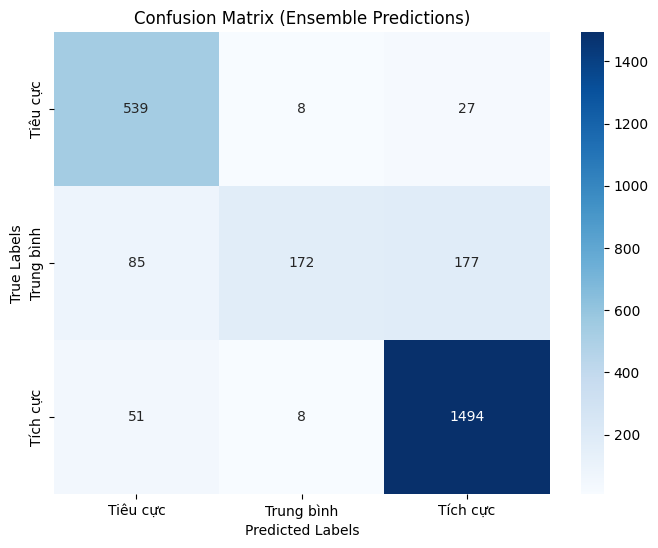

In [10]:
if 'real_labels_test' in locals() and real_labels_test is not None:
    cm = confusion_matrix(real_labels_test, predicted_labels_test)
    plt.figure(figsize=(8, 6))
    # Sử dụng CLASS_NAMES 3 lớp
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Ensemble Predictions)')
    plt.show()
else:
    print("Cannot plot heatmap because testing results are not available.")

In [11]:
def check_wrong(real_values, predicts, df_source, class_names):
    wrong_df_list = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            original_row = df_source.iloc[i].copy()
            original_row['Predicted_Label_Index'] = predicts[i]
            original_row['Real_Label_Index'] = real_values[i]
            # Lấy tên lớp từ class_names
            original_row['Predicted_Label'] = class_names[predicts[i]]
            original_row['Real_Label'] = class_names[real_values[i]]
            wrong_df_list.append(original_row)
    if not wrong_df_list: return pd.DataFrame()
    return pd.DataFrame(wrong_df_list)

if 'real_labels_test' in locals() and real_labels_test is not None and all_df is not None:
    print("\n--- Analyzing Misclassified Examples ---")
    # Sử dụng CLASS_NAMES 3 lớp
    wrong_predictions_df = check_wrong(real_labels_test, predicted_labels_test, all_df, CLASS_NAMES)

    if not wrong_predictions_df.empty:
        print(f"Total misclassified samples: {len(wrong_predictions_df)}")
        num_samples_to_show = min(15, len(wrong_predictions_df))
        print(f"\nDisplaying {num_samples_to_show} random misclassified samples:")
        pd.set_option('display.max_colwidth', 200)
        # Hiển thị cột Sentence, Real_Label, Predicted_Label
        print(wrong_predictions_df.sample(num_samples_to_show)[['Sentence', 'Real_Label', 'Predicted_Label']])

        print("\nCommon Misclassification Pairs (Real -> Predicted):")
        print(wrong_predictions_df.groupby(['Real_Label', 'Predicted_Label']).size().sort_values(ascending=False))
    else:
        print("Congratulations! No misclassified examples found in the test set!")
else:
    print("Cannot show misclassified examples because testing results or original data are not available.")


--- Analyzing Misclassified Examples ---
Total misclassified samples: 356

Displaying 15 random misclassified samples:
                                                                                                                                                                                Sentence  \
648   mua chưa được 20 ngày mà bị hư 2 lần. mà 1 lần đợi xuống coi thì 3, 4 ngày. giờ ngồi ngó chứ có sử dụng được đâu. mua hàng bên điện máy xanh rất nhiều nhưng lần này thất vọng quá   
67                                                                                                                                                                      quạt chạy êm mat   
1151                                                      máy ép mới dùng lần đầu tiên ép tách nước ok, nhưng qua lần thứ 2 trở đi thì ép giống như nước sinh tố, có xác ở trong nước ép   
2493                                                                                                                            

In [12]:
def infer_ensemble(text, tokenizer, max_len, n_classes, class_names, n_splits, device):
    print(f'\n--- Inference ---')
    print(f'Input Text: {text}')

    # 1. Load models
    models = []
    for fold in range(n_splits):
        model_path = f'phobert_sentiment_fold{fold+1}.pth'
        if os.path.exists(model_path):
            # Khởi tạo model với đúng số lớp
            model = SentimentClassifier(n_classes=n_classes)
            try:
                model.load_state_dict(torch.load(model_path, map_location=device))
                model.to(device)
                model.eval()
                models.append(model)
            except Exception as e:
                 print(f"Warning: Could not load model {model_path}. Error: {e}")
        else:
            print(f"Warning: Model file not found for fold {fold+1} at {model_path}")

    if not models:
        print("Error: No models loaded for inference.")
        return "Error: No models available", {}

    # 2. Preprocess text
    processed_text = ' '.join(simple_preprocess(text))
    tokenized_text = ViTokenizer.tokenize(processed_text)

    # 3. Encode text
    try:
        encoded_input = tokenizer.encode_plus(
            tokenized_text, max_length=max_len, truncation=True,
            add_special_tokens=True, padding='max_length',
            return_attention_mask=True, return_token_type_ids=False,
            return_tensors='pt',
        )
    except Exception as e:
        print(f"Error encoding input text: {e}")
        return "Error: Encoding failed", {}

    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # 4. Ensemble Prediction
    all_outputs = []
    with torch.no_grad():
        for model in models:
            outputs = model(input_ids, attention_mask)
            all_outputs.append(outputs)

    # 5. Average results and get prediction
    stacked_outputs = torch.stack(all_outputs)
    mean_outputs = torch.mean(stacked_outputs, dim=0)
    probabilities = torch.softmax(mean_outputs, dim=1)[0]
    final_pred_index = torch.argmax(mean_outputs, dim=1).item()

    # Sử dụng class_names 3 lớp
    predicted_label = class_names[final_pred_index]

    print(f'Processed Text: {tokenized_text}')
    print(f'Predicted Label: {predicted_label}')
    prob_dict = {name: f"{prob.item():.4f}" for name, prob in zip(class_names, probabilities.cpu())}
    print(f'Probabilities: {prob_dict}')
    return predicted_label, prob_dict

# --- Chạy thử Inference ---
if 'tokenizer' in locals() and N_SPLITS > 0:
     print("\n--- Running Inference Examples ---")
     # Ví dụ cần có đủ 3 lớp trong dữ liệu huấn luyện để có ý nghĩa
     infer_ensemble('quạt này dùng thích thật sự, mát mà êm', tokenizer, MAX_LEN, N_CLASSES, CLASS_NAMES, N_SPLITS, device)
     print("-" * 20)
     infer_ensemble('chất lượng quá kém, mới mua đã kêu to, không làm mát', tokenizer, MAX_LEN, N_CLASSES, CLASS_NAMES, N_SPLITS, device)
     print("-" * 20)
     infer_ensemble('quạt cũng bình thường, làm mát tạm được, hơi ồn chút', tokenizer, MAX_LEN, N_CLASSES, CLASS_NAMES, N_SPLITS, device) # Ví dụ cho lớp trung bình
else:
     print("\nCannot run inference example. Tokenizer not loaded or no models trained.")


--- Running Inference Examples ---

--- Inference ---
Input Text: quạt này dùng thích thật sự, mát mà êm
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Initializing SentimentClassifier for 3 classes...
Pre-trained PhoBERT base model loaded.
Classifier head initialized.
Processed Text: quạt này dùng thích thật_sự mát mà êm
Predicted Label: Tích cực
Probabilities: {'Tiêu cực': '0.0277', 'Trung bình': '0.0673', 'Tích cực': '0.9050'}
--------------------

--- Inference ---
Input Text: chất lượng quá kém, mới mua đã kêu to, không làm mát
Initializing SentimentClassifier fo